<a href="https://colab.research.google.com/github/HarshitaMBharadwaj/Fuel_Forward/blob/main/Auto_MPG_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

In [ ]:
from warnings import filterwarnings
filterwarnings("ignore")

In [1]:
%%capture
!pip install ucimlrepo

## Data Loading


### Auto MPG Dataset

https://archive.ics.uci.edu/dataset/9/auto+mpg

The Auto MPG dataset provides information about automobile fuel efficiency, in terms of miles per gallon (MPG).

We'll be using a version of this dataset hosted by UCI. They have a great repository of machine learning datasets, and now a cool new website and python package we can use to load the data easily:


In [18]:
from ucimlrepo import fetch_ucirepo

repo = fetch_ucirepo(id=9)
print(type(repo)) # assuming this is dictionary-like

<class 'ucimlrepo.dotdict.dotdict'>


In [19]:
repo.keys()

dict_keys(['data', 'metadata', 'variables'])

Repo has data, metadata (dataset description), and variables (data dictionary of sorts).

In [20]:
repo.metadata

{'uci_id': 9,
 'name': 'Auto MPG',
 'repository_url': 'https://archive.ics.uci.edu/dataset/9/auto+mpg',
 'data_url': 'https://archive.ics.uci.edu/static/public/9/data.csv',
 'abstract': 'Revised from CMU StatLib library, data concerns city-cycle fuel consumption',
 'area': 'Other',
 'tasks': ['Regression'],
 'characteristics': ['Multivariate'],
 'num_instances': 398,
 'num_features': 7,
 'feature_types': ['Real', 'Categorical', 'Integer'],
 'demographics': [],
 'target_col': ['mpg'],
 'index_col': ['car_name'],
 'has_missing_values': 'yes',
 'missing_values_symbol': 'NaN',
 'year_of_dataset_creation': 1993,
 'last_updated': 'Thu Aug 10 2023',
 'dataset_doi': '10.24432/C5859H',
 'creators': ['R. Quinlan'],
 'intro_paper': None,
 'additional_info': {'summary': 'This dataset is a slightly modified version of the dataset provided in the StatLib library.  In line with the use by Ross Quinlan (1993) in predicting the attribute "mpg", 8 of the original instances were removed because they had 

In [21]:
repo.variables

,name,role,type,demographic,description,units,missing_values
0,displacement,Feature,Continuous,None,None,None,no
1,mpg,Target,Continuous,None,None,None,no
2,cylinders,Feature,Integer,None,None,None,no
3,horsepower,Feature,Continuous,None,None,None,yes
4,weight,Feature,Continuous,None,None,None,no
5,acceleration,Feature,Continuous,None,None,None,no
6,model_year,Feature,Integer,None,None,None,no
7,origin,Feature,Integer,None,None,None,no
8,car_name,ID,Categorical,None,None,None,no


We see the target is "mpg" and there are a number of features - some continuous, some categorical. We'll need to further investigate and decide how to encode the categorical features.

We see there are some missing values in the "horsepower" column. We'll need to handle them later.

Finally, here is our dataset:

In [22]:
df = repo.data.original
df.head()

,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,mpg
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,1,18.0
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,1,15.0
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,1,18.0
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,1,16.0
4,"ford,torino",8,302.0,140.0,3449,10.5,70,1,17.0


What's the "origin" feature about?

One can possibly interpret from the car names, or consult various [internet](https://rstudio-pubs-static.s3.amazonaws.com/516461_09a0ec8250df45c4bb362c97ad7fd965.html) [resources](https://www.kaggle.com/code/asokraju/auto-mpg-dataset), that mention the following mapping: (1: USA, 2: Europe, 3: Asia).

In [26]:
df[df["origin"] == 1]["car_name"]
df[df["origin"] == 2]["car_name"]
df[df["origin"] == 3]["car_name"]

14     toyota,corona,mark,ii
18              datsun,pl510
29              datsun,pl510
31             toyota,corona
53       toyota,corolla,1200
               ...          
382           toyota,corolla
383              honda,civic
384       honda,civic,(auto)
385            datsun,310,gx
390         toyota,celica,gt
Name: car_name, Length: 79, dtype: object

In [27]:
ORIGINS_MAP = {1: "usa", 2: "europe", 3: "asia"}
df["origin"] = df["origin"].map(ORIGINS_MAP)
df["origin"]

0         usa
1         usa
2         usa
3         usa
4         usa
        ...  
393       usa
394    europe
395       usa
396       usa
397       usa
Name: origin, Length: 398, dtype: object

## Data Cleaning

In [44]:
ORIGINS_MAP = {1: "usa", 2: "europe", 3: "asia"}
df["origin"] = df["origin"].map(ORIGINS_MAP)
df["origin"]

car_name        0
cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
origin          0
mpg             0
dtype: int64


In [47]:
# one hot encodinh the origin
from pandas import get_dummies as one_hot_encode
if "origin" in df.columns:

    df = one_hot_encode(df, columns=["origin"])
df

,car_name,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg,origin_asia,origin_europe,origin_usa
0,"chevrolet,chevelle,malibu",8,307.0,130.0,3504,12.0,70,18.0,0,0,1
1,"buick,skylark,320",8,350.0,165.0,3693,11.5,70,15.0,0,0,1
2,"plymouth,satellite",8,318.0,150.0,3436,11.0,70,18.0,0,0,1
3,"amc,rebel,sst",8,304.0,150.0,3433,12.0,70,16.0,0,0,1
4,"ford,torino",8,302.0,140.0,3449,10.5,70,17.0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
393,"ford,mustang,gl",4,140.0,86.0,2790,15.6,82,27.0,0,0,1
394,"vw,pickup",4,97.0,52.0,2130,24.6,82,44.0,0,1,0
395,"dodge,rampage",4,135.0,84.0,2295,11.6,82,32.0,0,0,1
396,"ford,ranger",4,120.0,79.0,2625,18.6,82,28.0,0,0,1


In [55]:
data=df.drop("car_name",axis=1)
data.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg,origin_asia,origin_europe,origin_usa
0,8,307.0,130.0,3504,12.0,70,18.0,0,0,1
1,8,350.0,165.0,3693,11.5,70,15.0,0,0,1
2,8,318.0,150.0,3436,11.0,70,18.0,0,0,1
3,8,304.0,150.0,3433,12.0,70,16.0,0,0,1
4,8,302.0,140.0,3449,10.5,70,17.0,0,0,1


## Data Exploration

In [58]:
print(data.columns)

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model_year', 'mpg', 'origin_asia', 'origin_europe', 'origin_usa'],
      dtype='object')


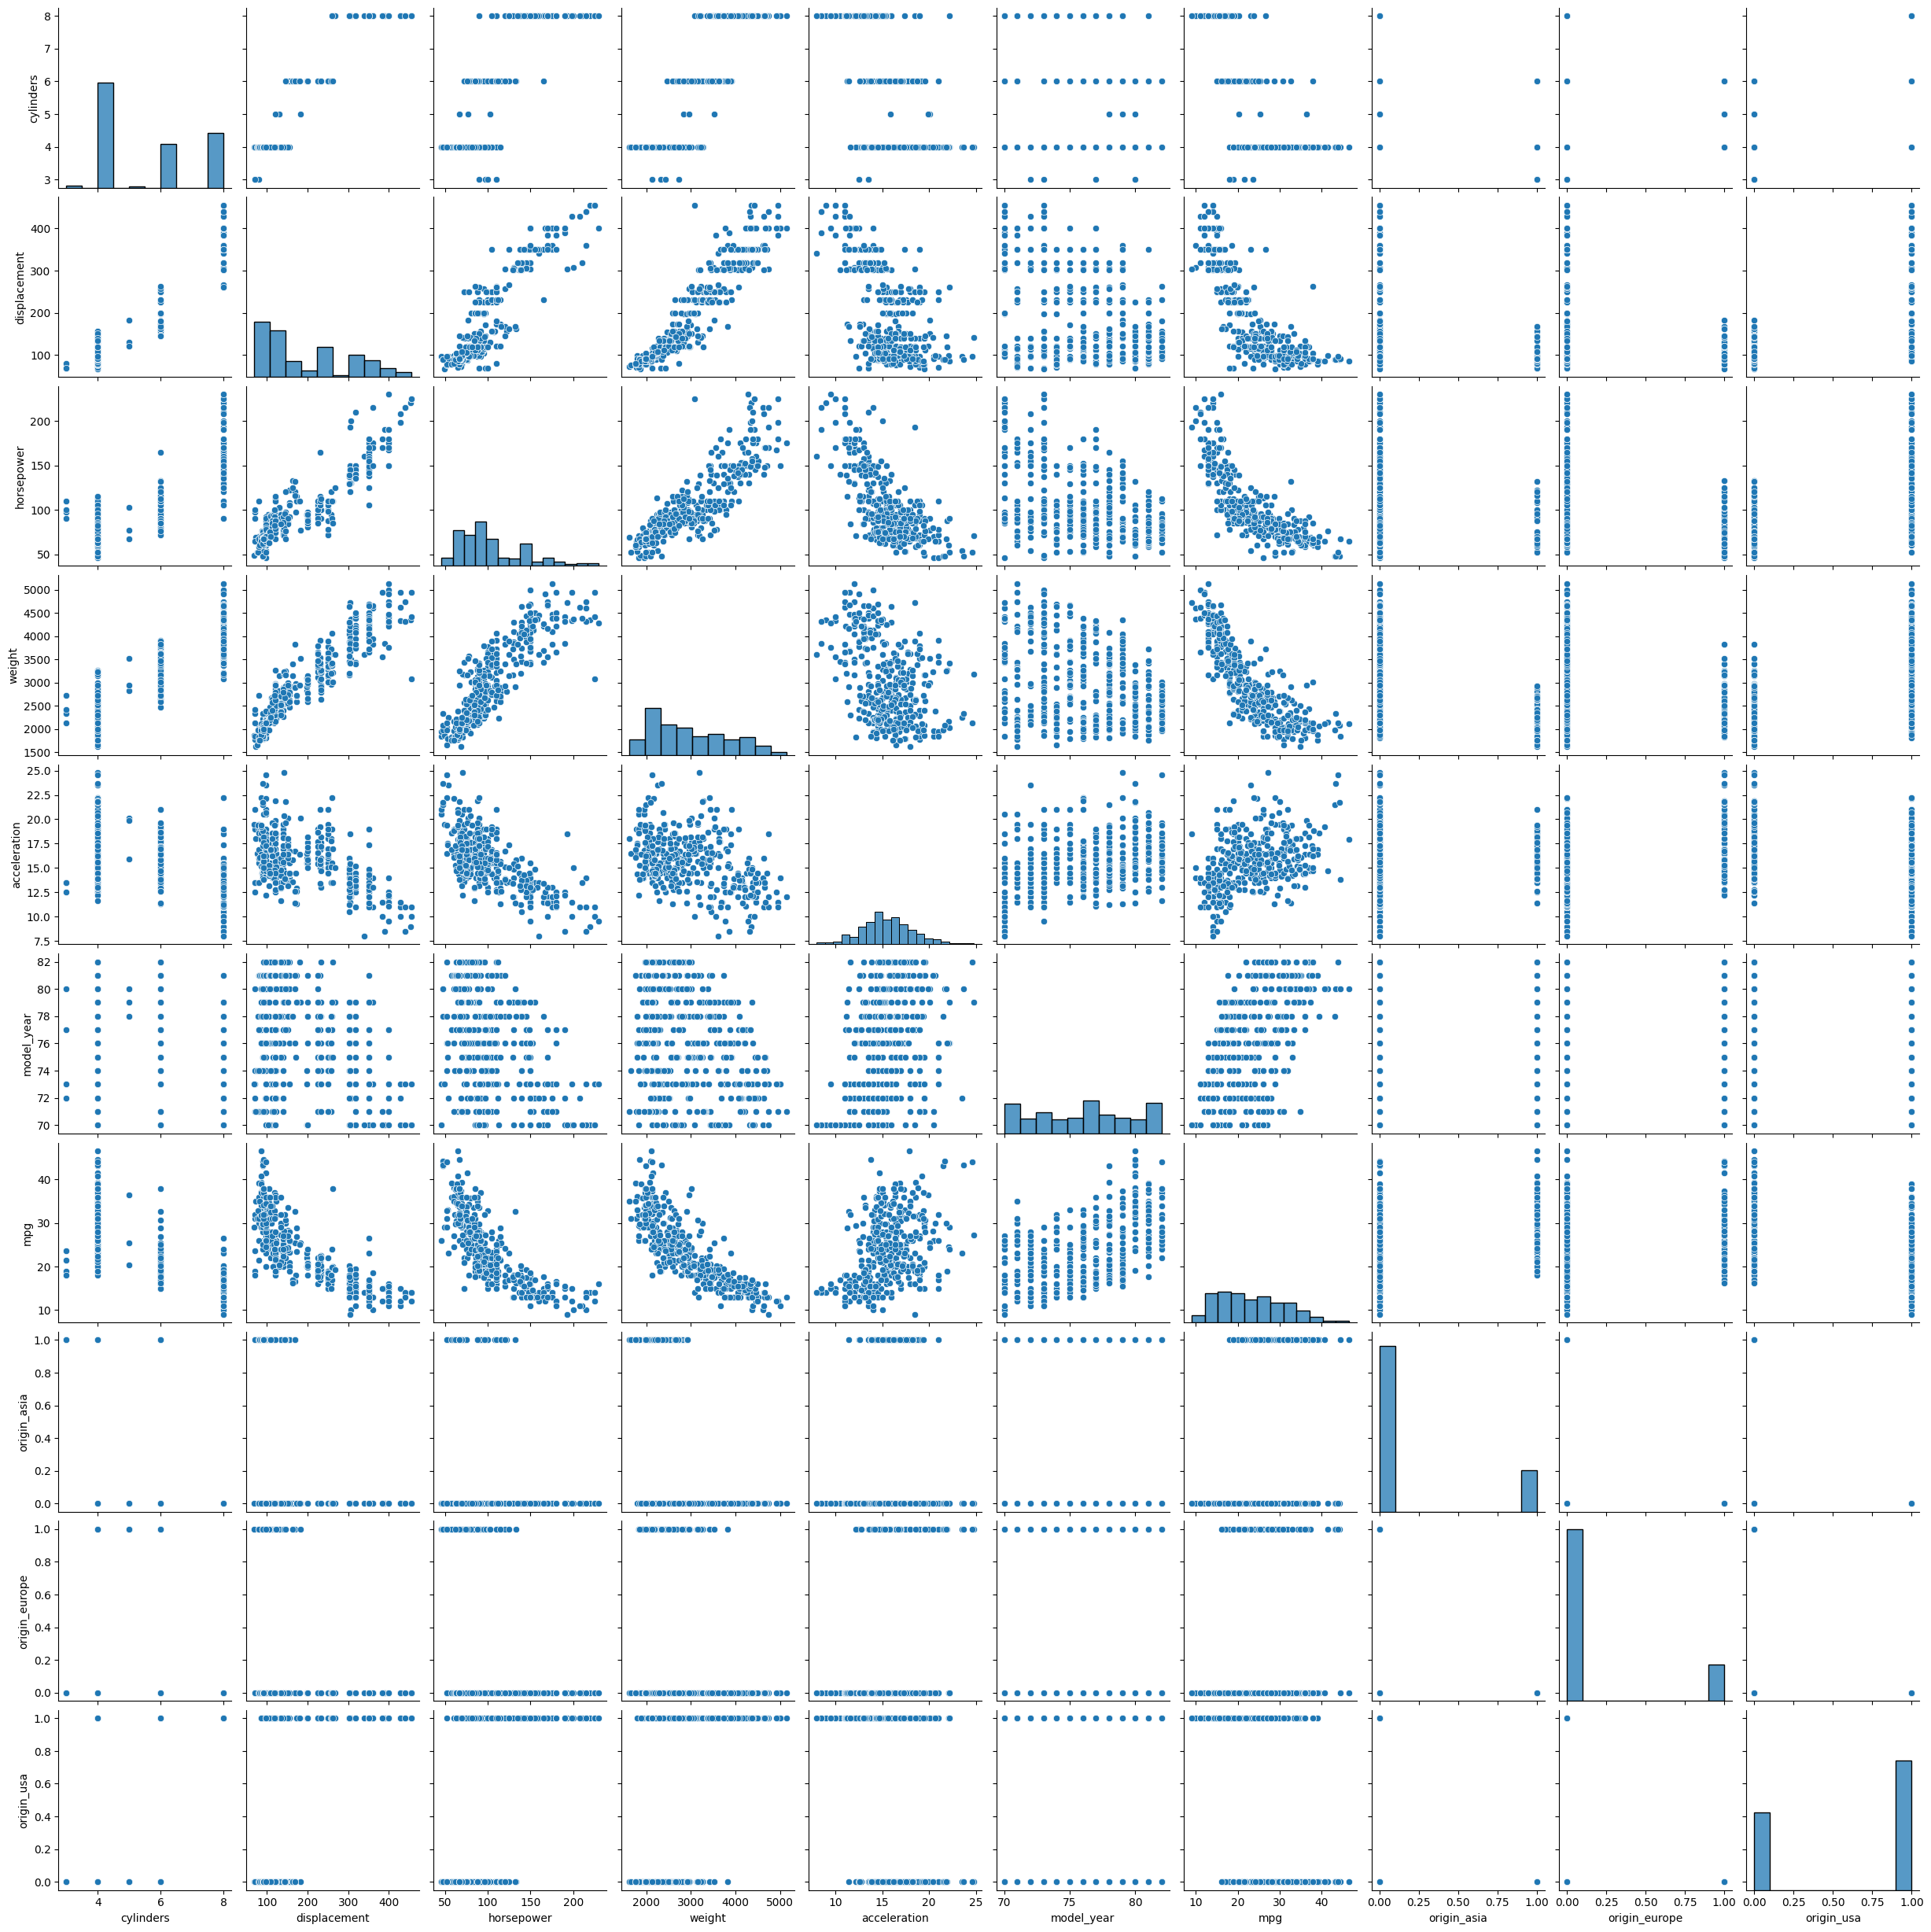

In [61]:
import seaborn as sns

sns.pairplot(data)

## Model selection and testing

x and y :

In [65]:
#choosing Dependent and Independent variables

y =data['mpg']
x =data.drop("mpg",axis=1)
print(x.head())
print(y.head())

   cylinders  displacement  horsepower  weight  acceleration  model_year  \
0          8         307.0       130.0    3504          12.0          70   
1          8         350.0       165.0    3693          11.5          70   
2          8         318.0       150.0    3436          11.0          70   
3          8         304.0       150.0    3433          12.0          70   
4          8         302.0       140.0    3449          10.5          70   

   origin_asia  origin_europe  origin_usa  
0            0              0           1  
1            0              0           1  
2            0              0           1  
3            0              0           1  
4            0              0           1  
0    18.0
1    15.0
2    18.0
3    16.0
4    17.0
Name: mpg, dtype: float64


Feature Scaling :
1) Min max sacling
2) Standard scaling

When we check for sacling all the std dev should be 1 and all the means should be close to zero.



In [66]:
x.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_asia,origin_europe,origin_usa
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,0.201531,0.173469,0.625000
std,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.401656,0.379136,0.484742
min,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,0.000000,0.000000,0.000000
25%,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,0.000000,0.000000,0.000000
50%,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,0.000000,0.000000,1.000000
75%,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,0.000000,0.000000,1.000000
max,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,1.000000,1.000000,1.000000


In [72]:
x.mean(axis=0)

cylinders           5.471939
displacement      194.411990
horsepower        104.469388
weight           2977.584184
acceleration       15.541327
model_year         75.979592
origin_asia         0.201531
origin_europe       0.173469
origin_usa          0.625000
dtype: float64

In [73]:
import numpy as np
x_scaled=(x-x.mean(axis=0))/x.std(axis=0)
x_scaled.describe()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin_asia,origin_europe,origin_usa
count,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02,3.920000e+02
mean,-7.250436e-17,-5.437827e-17,-1.631348e-16,3.625218e-17,4.350262e-16,-1.232574e-15,-1.812609e-17,3.851794e-17,-4.531523e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.449152e+00,-1.208019e+00,-1.519034e+00,-1.606522e+00,-2.733490e+00,-1.623241e+00,-5.017492e-01,-4.575381e-01,-1.289347e+00
25%,-8.629108e-01,-8.544397e-01,-7.656144e-01,-8.857216e-01,-6.402369e-01,-8.088504e-01,-5.017492e-01,-4.575381e-01,-1.289347e+00
50%,-8.629108e-01,-4.148541e-01,-2.849846e-01,-2.049490e-01,-1.497955e-02,5.540071e-03,-5.017492e-01,-4.575381e-01,7.736080e-01
75%,1.482053e+00,7.772830e-01,5.593651e-01,7.501341e-01,5.377842e-01,8.199306e-01,-5.017492e-01,-4.575381e-01,7.736080e-01
max,1.482053e+00,2.490234e+00,3.261284e+00,2.545808e+00,3.355973e+00,1.634321e+00,1.987943e+00,2.180035e+00,7.736080e-01


## Model Training and Evaluation

In [74]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=99)
print("TRAIN:", x_train.shape, y_train.shape)
print("TEST:", x_test.shape, y_test.shape)

TRAIN: (294, 9) (294,)
TEST: (98, 9) (98,)


In [80]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

model.fit(x_train, y_train)

print("COEFS:", model.coef_) # one for each feature
print("Y INTERCEPT:", model.intercept_)

COEFS: [-0.41348718  0.01981207 -0.01188427 -0.00620766  0.10999823  0.78574931
  1.06694192  1.09907767 -2.1660196 ]
Y INTERCEPT: -19.01654894812158


In [81]:
y_pred = model.predict(x_test)


In [84]:
from sklearn.metrics import r2_score, mean_squared_error

In [83]:
# Calculate R-squared score
r_squared = r2_score(y_test, y_pred)
print("R-squared score:", r_squared)

R-squared score: 0.7782076471080802


In [85]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 13.472944137027957


In [86]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 3.6705509309949584


In [87]:
from pandas import Series

coefs = Series(model.coef_, index=x_scaled.columns)
coefs.sort_values(ascending=False)

origin_europe    1.099078
origin_asia      1.066942
model_year       0.785749
acceleration     0.109998
displacement     0.019812
weight          -0.006208
horsepower      -0.011884
cylinders       -0.413487
origin_usa      -2.166020
dtype: float64